# Churn prediction model
## Developing and Deploying a model in Watson Studio

#### Summary

This project teaches the basic about developing and deploying a machine learning model in from IBM Watson Studio to the IBM cloud. It consist in using data client data from a telecommunication company to create a model that predicts if a customer is going to churn or not, we will go through the basic steps of model building but have a focus on training and deploying the model with diferent libraries to make sure all the common cases are covered.

As for the datasets characteristics, it containes 7043 rows (customers) and 21 columns (features) which includes gender, tenure, if the customer is a senior citizen and many others so there is information for our model to learn. The data, as seen during the cleaning, is mostly out of null values and ready to use. Afterwards we check the correlation between features but since not all of them are of thesame type then it was necessary to use two types of correlation measures. It also is important to state that there is a heavy overrepresentation of "No churn" cases which would need to be oversampled to correctly train the model. Finally it was decided on a Logistic Regresion model since it is was on the simplest to apply and most common to use.

#### Packages

- numpy
- pandas
- matplotlib
- seaborn
- watson_machine_learning_client
- botocore
- ibm_boto3
- scikit-learn -> 0.20.0
- imbalanced-learn -> 0.4.3

#### Remark

The Watson ML library it only able to deploy scikit-learn models from version <= 0.20.0 so keep this in mind

#### Links and Data Source

Data source: https://www.kaggle.com/blastchar/telco-customer-churn

Correlation between variables: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

#### Personal conclusion and acknowledgments

As a small conclusion I would like to say that I had a lot of fun making this tutorial, Data Analysis and model building are very scary areas to get into since there is so much to learn and heavy math involved but luckily modern tools and libraries can save us some work. Although I had some training in the area before hand but it is always good to refresh knwoledge and learn new stuff(stackoverflow is the way). As a final work I would like to say thank you to my data preparation professor Robert Nisbet at UCI, his class helped me a lot and gave me a clear view for this project.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
from watson_machine_learning_client import WatsonMachineLearningAPIClient

## Reading data from source

In [6]:
#From local computer
data = pd.read_csv("churn-dataset.csv")
"""
#From IBM COS
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_1d7fd3936d244337a5cb0e975018dfb0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='**************************',
    ibm_auth_endpoint="**********************",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_1d7fd3936d244337a5cb0e975018dfb0.get_object(Bucket='telcouserchurn-donotdelete-pr-ekk0uryv60v8ov',Key='churn-dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
"""
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dropping uneeded index column



In [7]:
data = data.drop(['customerID'], axis=1)
data.shape

(7043, 20)

## Checking for nulls values
It is always important to look out for null values that we could fix or erase to increase available information from where to train the model. We didn't find any at this time so we can omit this step for now.

In [8]:
df = data
df.isnull().sum().sort_values(ascending = False)

Churn               0
TotalCharges        0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
gender              0
dtype: int64

## Data type correction and cleaning

1. We should always check the datatype to make sure all data was imported correctly as pandas is making assumptions about feature types.

In [9]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

2. We can appreciate that "TotalCharges" is assumed as an object but its values look like numbers, it was wrongly assumed and has to be converted

In [10]:
for col in df.columns:
    print(col, "->",df[col].unique()[:5])

gender -> ['Female' 'Male']
SeniorCitizen -> [0 1]
Partner -> ['Yes' 'No']
Dependents -> ['No' 'Yes']
tenure -> [ 1 34  2 45  8]
PhoneService -> ['No' 'Yes']
MultipleLines -> ['No phone service' 'No' 'Yes']
InternetService -> ['DSL' 'Fiber optic' 'No']
OnlineSecurity -> ['No' 'Yes' 'No internet service']
OnlineBackup -> ['Yes' 'No' 'No internet service']
DeviceProtection -> ['No' 'Yes' 'No internet service']
TechSupport -> ['No' 'Yes' 'No internet service']
StreamingTV -> ['No' 'Yes' 'No internet service']
StreamingMovies -> ['No' 'Yes' 'No internet service']
Contract -> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -> ['Yes' 'No']
PaymentMethod -> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges -> [29.85 56.95 53.85 42.3  70.7 ]
TotalCharges -> ['29.85' '1889.5' '108.15' '1840.75' '151.65']
Churn -> ['No' 'Yes']


3. Use "pd.to_numeric" to covert a column from its original type to a number and the parameter "error" with the coerce values sets all unconvertable values as null

In [11]:
df_refined = df
for col in df.columns:
    if not (col in ["MonthlyCharges", "TotalCharges", "tenure"]):
        df_refined[col] = df[col].astype('category')
    else:
        df_refined[col] = pd.to_numeric(df[col], errors="coerce")

4. From the last line we have created 11 null values for the "TotalCharges" column

##### Remark: It is always a good idea to fill the missing values to obtain more information but since theey are a really small portion of the whole dataset we are just going to omit them(A tutorial regarding filling null values is on the way)

In [12]:
df_refined["TotalCharges"].isnull().sum()

11

In [13]:
df_refined = df_refined.dropna()

## Data Analysis

1. Now that we made sure that our data has no missing values, it is time to take a look at the value distribution. As  expected in real data, target variable is unbalanced and this damage the training process of our model.

##### Remark: You should always take a look at all features and no only the target variables. Use your business knowledge to help accelerate the features selection process.(To save time and space, and keep in scope of the tutorial, only the target variable was visualized)

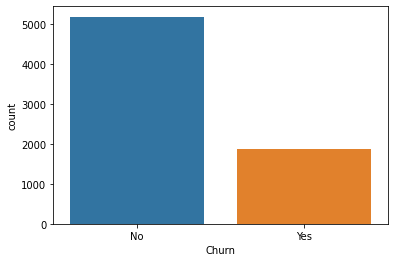

In [17]:
ax = sns.countplot(x="Churn", data=df)
plt.show()

2. Next is to measure the correlation between features to make sure there are no overlapping between them. As our model has categorical and continous features, we cannot use the regular pearson formula for all. Below there is a matrix of posible metrics to use depending on the situation(The link to the source is at the top of the tutorial)


<img src="Images/IMG_BD_Corr_CatvsCon.png" width="60%">.

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
df_categorical = df_refined.drop(["MonthlyCharges", "TotalCharges", "tenure"], axis=1)
corr_matrix = pd.DataFrame ({}, columns = df_categorical.columns)
for col1 in df_categorical.columns:
    v = []
    i = []
    for col2 in df_categorical.columns:
        c = cramers_v(df_categorical[col1], df_categorical[col2])
        if(c > 0.75 and col1 != col2):
            print(col1, "->", col2, "=", c)
        v.append(c)
        i.append(col2)
    corr_matrix[col1] = pd.Series(v, index =i)

PhoneService -> MultipleLines = 0.9999288737151917
MultipleLines -> PhoneService = 0.9999288737151917
StreamingTV -> StreamingMovies = 0.7711317093428717
StreamingMovies -> StreamingTV = 0.7711317093428717


3. As we can see there are a 2 features that share almost 100% correlation so there is no value in keeping them both. "PhoneService" has more attributes so we are keeping that one.

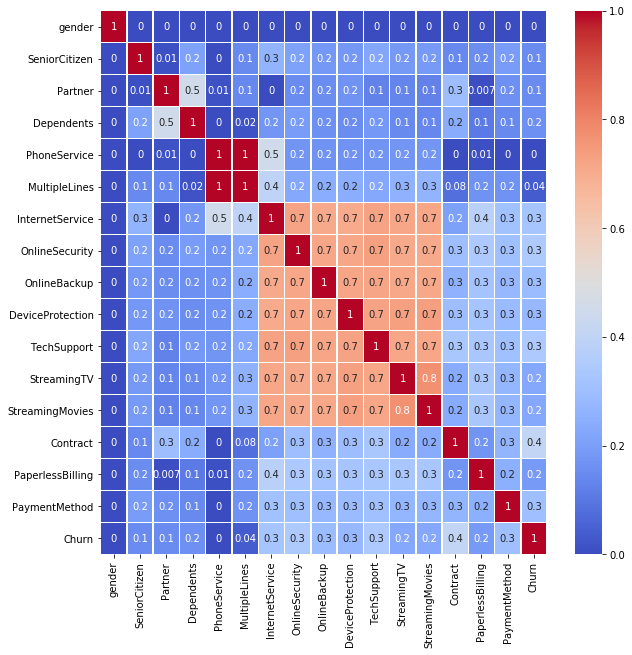

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot = True, fmt='.1g', linewidths=.5, ax=ax, cmap= 'coolwarm')

In [10]:
df_refined[["MonthlyCharges", "TotalCharges", "tenure"]].corr(method="pearson")

,MonthlyCharges,TotalCharges,tenure
MonthlyCharges,1.000000,0.651065,0.246862
TotalCharges,0.651065,1.000000,0.825880
tenure,0.246862,0.825880,1.000000


## Splitting data

The data is being divided into 70%-30% for the training and testing dataset

In [201]:
X_data = df_refined.drop(["PhoneService", "Churn"], axis=1)
Y_data = df_refined["Churn"]

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=0)

gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
dtype: object


## Oversampling of data

Before we saw that our data had an underrepresentation of "Churn=yes" cases, it important to equalize this situation to ensure that our model learns correctly. The SMOTE technique was used over the training dataset to solve this situation.

In [259]:
cols = list(X_data.columns)

In [208]:
os = SMOTENC(random_state=0, categorical_features=[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15])
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=cols)
os_data_y = pd.DataFrame(data=os_data_y,columns=['Churn'])

print("length of oversampled data is ",len(os_data_X))
print("Number of Churn",len(os_data_y[os_data_y['Churn']=="Yes"]))
print("Number of No Churn",len(os_data_y[os_data_y['Churn']=="No"]))
print("Proportion of Churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']=="Yes"])/len(os_data_X))
print("Proportion of No Churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']=="No"])/len(os_data_X))

gender              object
SeniorCitizen       object
Partner             object
Dependents          object
tenure              object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
dtype: object
length of oversampled data is  7216
Number of Churn 3608
Number of No Churn 3608
Proportion of Churn data in oversampled data is  0.5
Proportion of No Churn data in oversampled data is  0.5


In [213]:
X_train_num = os_data_X[["MonthlyCharges", "TotalCharges", "tenure"]]
for col in X_train_num.columns:
    X_train_num[col] = pd.to_numeric(X_train_num[col], errors="coerce")

## One-Hot Encoding categorical variables

The next step is to encode our categorical features since ML models require numbers but at the same time our features are not continous.

In [221]:
temp_cat = pd.get_dummies(os_data_X.drop(["MonthlyCharges", "TotalCharges", "tenure"], axis=1), drop_first=True)
X_train = pd.concat([temp_cat, X_train_num], axis=1, join='inner')
Y_train = pd.get_dummies(os_data_y, drop_first=True)

temp_cat = pd.get_dummies(X_test.drop(["MonthlyCharges", "TotalCharges", "tenure"], axis=1), drop_first=True)
X_test = pd.concat([temp_cat, X_test[["MonthlyCharges", "TotalCharges", "tenure"]]], axis=1, join='inner')
Y_test = pd.get_dummies(y_test, drop_first=True)

## Training ML model

In [222]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, Y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [223]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.77


In [225]:
conf_matrix = confusion_matrix(Y_test, y_pred)
print(conf_matrix)

[[1209  346]
 [ 144  411]]


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1064
           1       0.78      0.85      0.81      1101

   micro avg       0.80      0.80      0.80      2165
   macro avg       0.80      0.80      0.80      2165
weighted avg       0.80      0.80      0.80      2165



## Deploying to as API to Watson ML

Ok, finally we have arrived at the deploying of the model. The credentilas of the instance are declared and the model stored in the Watson ML storage, then we use the Uid to deploy it(It does not appear in the deployment section but it is there).

In [229]:
wml_credentials={
    "apikey": "*****************************",
    "instance_id": "************************",
    "url": "********************************"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

### Store model in WML repository

In [235]:
model_props={
    client.repository.ModelMetaNames.NAME: "Logistic Regression Churn model", 
    client.repository.ModelMetaNames.AUTHOR_EMAIL: "diegoramirez@gmail.com",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "0.20",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "scikit-learn"
}

model_artifact=client.repository.store_model(logreg, meta_props=model_props)

In [236]:
client.repository.list()

------------------------------------  -------------------------------  ------------------------  -----------------  -----
GUID                                  NAME                             CREATED                   FRAMEWORK          TYPE
f1cf615d-d9a9-436c-9771-88df97c7e6ec  Logistic Regression Churn model  2020-05-20T02:43:02.470Z  scikit-learn-0.20  model
------------------------------------  -------------------------------  ------------------------  -----------------  -----


### Deploy model to Watson Machine Learning

In [237]:
#Get model UID
published_model_uid = client.repository.get_model_uid(model_artifact)
#Deploy the model
created_deployment = client.deployments.create(published_model_uid, name="ChurnModelDeployment")



#######################################################################################

Synchronous deployment creation for uid: 'f1cf615d-d9a9-436c-9771-88df97c7e6ec' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f9e80285-841e-4783-bea0-0c76bf8a8ec4'
------------------------------------------------------------------------------------------------




In [ ]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)

In [258]:
scoring_payload = {"fields": list(X_test.columns),
    "values":X_test.iloc[11:20].values.tolist()}
predictions = client.deployments.score(scoring_endpoint, scoring_payload)
print(predictions)

{'fields': ['prediction', 'probability'], 'values': [[0, [0.9849121857890184, 0.01508781421098155]], [0, [0.7668201230777614, 0.23317987692223857]], [0, [0.9977147998805967, 0.0022852001194032597]], [0, [0.975127668806959, 0.024872331193040997]], [0, [0.7327641504178833, 0.26723584958211666]], [0, [0.9916415671999173, 0.008358432800082749]], [1, [0.37651074677061636, 0.6234892532293836]], [0, [0.9986890733149208, 0.0013109266850791436]], [0, [0.9828675236249786, 0.017132476375021317]]]}
